## Packages, Library Imports, File Mounts, & Data Imports ** Run All **

In [1]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -q datasets
!pip install -q evaluate
!pip install -q nltk
!pip install -q contractions
!pip install -q hf_xet
!pip install -q sentencepiece
# !pip install -q import openpyxl

In [2]:
!sudo apt-get update
! sudo apt-get install tree

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [3]:
#@title Imports
import nltk
from nltk.tokenize import RegexpTokenizer
import sentencepiece
import contractions
import spacy


import evaluate
from datasets import load_dataset, Dataset, DatasetDict

import torch
import torch.nn as nn
from torchinfo import summary

import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, BertForSequenceClassification

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

import json
import datetime
import zoneinfo
from datetime import datetime

import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy

In [4]:
# @title Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dir_root = '/content/drive/MyDrive/266-final/'
# dir_data = '/content/drive/MyDrive/266-final/data/'
# dir_data = '/content/drive/MyDrive/266-final/data/se21-t1-comp-lex-master/'
dir_data = '/content/drive/MyDrive/266-final/data/266-comp-lex-master'
dir_models = '/content/drive/MyDrive/266-final/models/'
dir_results = '/content/drive/MyDrive/266-final/results/'
log_filename = "experiment_runs.txt"
log_filepath = os.path.join(dir_results, log_filename)

In [7]:
wandbai_api_key = ""

In [8]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [9]:
!ls -R /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/:
fe-test-labels	fe-train  fe-trial-val	test-labels  train  trial

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels:
test_multi_df.csv  test_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train:
train_multi_df.csv  train_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val:
trial_val_multi_df.csv	trial_val_single_df.csv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/test-labels:
lcp_multi_test.tsv  lcp_single_test.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/train:
lcp_multi_train.tsv  lcp_single_train.tsv

/content/drive/MyDrive/266-final/data/266-comp-lex-master/trial:
lcp_multi_trial.tsv  lcp_single_trial.tsv


In [10]:
!tree /content/drive/MyDrive/266-final/data/266-comp-lex-master/

/content/drive/MyDrive/266-final/data/266-comp-lex-master/
├── fe-test-labels
│   ├── test_multi_df.csv
│   └── test_single_df.csv
├── fe-train
│   ├── train_multi_df.csv
│   └── train_single_df.csv
├── fe-trial-val
│   ├── trial_val_multi_df.csv
│   └── trial_val_single_df.csv
├── test-labels
│   ├── lcp_multi_test.tsv
│   └── lcp_single_test.tsv
├── train
│   ├── lcp_multi_train.tsv
│   └── lcp_single_train.tsv
└── trial
    ├── lcp_multi_trial.tsv
    └── lcp_single_trial.tsv

6 directories, 12 files


In [11]:
#@title Import Data

In [12]:
df_names = [
    "train_single_df",
    "train_multi_df",
    "trial_val_single_df",
    "trial_val_multi_df",
    "test_single_df",
    "test_multi_df"
]

loaded_dataframes = {}

for df_name in df_names:
    if "train" in df_name:
        subdir = "fe-train"
    elif "trial_val" in df_name:
        subdir = "fe-trial-val"
    elif "test" in df_name:
        subdir = "fe-test-labels"
    else:
        subdir = None

    if subdir:
        read_path = os.path.join(dir_data, subdir, f"{df_name}.csv")
        loaded_df = pd.read_csv(read_path)
        loaded_dataframes[df_name] = loaded_df
        print(f"Loaded {df_name} from {read_path}")

# for df_name, df in loaded_dataframes.items():
#     print(f"\n>>> {df_name} shape: {df.shape}")
#     if 'binary_complexity' in df.columns:
#         print(df['binary_complexity'].value_counts())
#         print(df.info())
#         print(df.head())

for df_name, df in loaded_dataframes.items():
    globals()[df_name] = df
    print(f"{df_name} loaded into global namespace.")

Loaded train_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_single_df.csv
Loaded train_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-train/train_multi_df.csv
Loaded trial_val_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_single_df.csv
Loaded trial_val_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-trial-val/trial_val_multi_df.csv
Loaded test_single_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_single_df.csv
Loaded test_multi_df from /content/drive/MyDrive/266-final/data/266-comp-lex-master/fe-test-labels/test_multi_df.csv
train_single_df loaded into global namespace.
train_multi_df loaded into global namespace.
trial_val_single_df loaded into global namespace.
trial_val_multi_df loaded into global namespace.
test_single_df loaded into global namespace.
test_multi_df loaded into global namespace.


- Functional tests pass, we can proceed with Baseline Modeling

## Experiments

### Helper Functions ** Run **

In [13]:
MODEL_LINEAGE = {}

def get_model_and_tokenizer(
    remote_model_name: str = None,
    local_model_path: str = None,
    config=None
):
    """
    Loads the model & tokenizer for classification.
    If 'local_model_path' is specified, load from that path.
    Otherwise, fall back to 'remote_model_name'.

    Optional: 'config' can be a custom BertConfig/AutoConfig object
              to override certain configuration parameters.

    Records complete traceable lineage in the global MODEL_LINEAGE.
    """
    global MODEL_LINEAGE

    if local_model_path:
        print(f"Loading from local path: {local_model_path}")
        tokenizer = AutoTokenizer.from_pretrained(local_model_path)

        # If a config object is provided, we pass it to from_pretrained.
        # Otherwise, it just uses the config that is part of local_model_path.
        if config is not None:
            model = AutoModelForSequenceClassification.from_pretrained(
                local_model_path,
                config=config
            )
        else:
            model = AutoModelForSequenceClassification.from_pretrained(local_model_path)

        MODEL_LINEAGE = {
            "type": "offline_checkpoint",
            "path": local_model_path,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    elif remote_model_name:
        print(f"Loading from Hugging Face model: {remote_model_name}")
        tokenizer = AutoTokenizer.from_pretrained(remote_model_name)

        if config is not None:
            model = AutoModelForSequenceClassification.from_pretrained(
                remote_model_name,
                config=config
            )
        else:
            model = AutoModelForSequenceClassification.from_pretrained(remote_model_name)

        MODEL_LINEAGE = {
            "type": "huggingface_hub",
            "path": remote_model_name,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    else:
        raise ValueError("You must provide either a remote_model_name or a local_model_path!")

    return model, tokenizer


In [14]:
def freeze_unfreeze_layers(model, layers_to_unfreeze=None):
    """
    Toggles requires_grad = False for all parameters
    except for those whose names contain any string in layers_to_unfreeze.
    By default, always unfreeze classifier/heads.
    """
    if layers_to_unfreeze is None:
        layers_to_unfreeze = ["classifier.", "pooler."]

    for name, param in model.named_parameters():
        if any(substring in name for substring in layers_to_unfreeze):
            param.requires_grad = True
        else:
            param.requires_grad = False

In [15]:
def encode_examples(examples, tokenizer, text_col, max_length=256):
    """
    Tokenizes a batch of texts from 'examples[text_col]' using the given tokenizer.
    Returns a dict with 'input_ids', 'attention_mask', etc.
    """
    texts = examples[text_col]
    encoded = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    return encoded

In [16]:
def prepare_dataset(df, tokenizer, text_col, label_col, max_length=256):
    """
    Converts a Pandas DataFrame to a Hugging Face Dataset,
    then applies 'encode_examples' to tokenize.
    """
    dataset = Dataset.from_pandas(df)

    dataset = dataset.map(
        lambda batch: encode_examples(batch, tokenizer, text_col, max_length),
        batched=True
    )

    dataset = dataset.rename_column(label_col, "labels")
    dataset.set_format(type='torch',
                       columns=['input_ids', 'attention_mask', 'labels'])
    return dataset

In [17]:
def compute_metrics(eval_pred):
    """
    Computes classification metrics, including accuracy, precision, recall, and F1.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    metric_accuracy  = evaluate.load("accuracy")
    metric_precision = evaluate.load("precision")
    metric_recall    = evaluate.load("recall")
    metric_f1        = evaluate.load("f1")

    accuracy_result  = metric_accuracy.compute(predictions=preds, references=labels)
    precision_result = metric_precision.compute(predictions=preds, references=labels, average="binary")
    recall_result    = metric_recall.compute(predictions=preds, references=labels, average="binary")
    f1_result        = metric_f1.compute(predictions=preds, references=labels, average="binary")

    return {
        "accuracy"       : accuracy_result["accuracy"],
        "precision": precision_result["precision"],
        "recall"   : recall_result["recall"],
        "f1"       : f1_result["f1"]
    }

In [18]:
def gather_config_details(model):
    """
    Enumerates every attribute in model.config
    """
    config_items = {}
    for attr_name, attr_value in vars(model.config).items():
        config_items[attr_name] = attr_value
    return config_items

def gather_model_details(model):
    """
    Extracts total layers, total params, trainable params, and activation function
    from a Transformers model. Adjust logic as needed for different architectures.
    """
    details = {}

    try:
        total_params = model.num_parameters()
        trainable_params = model.num_parameters(only_trainable=True)
    except AttributeError:
        all_params = list(model.parameters())
        total_params = sum(p.numel() for p in all_params)
        trainable_params = sum(p.numel() for p in all_params if p.requires_grad)

    details["model_total_params"] = total_params
    details["model_trainable_params"] = trainable_params

    if hasattr(model, "bert") and hasattr(model.bert, "pooler"):
        act_obj = getattr(model.bert.pooler, "activation", None)
        details["pooler_activation_function"] = act_obj.__class__.__name__ if act_obj else "N/A"
    else:
        details["pooler_activation_function"] = "N/A"

    details["config_attributes"] = gather_config_details(model)
    return details

def gather_all_run_metrics(trainer, train_dataset=None, val_dataset=None, test_dataset=None):
    """
    Gathers final training metrics, final validation metrics, final test metrics.
    Instead of only parsing the final train_loss from the log, we also do a full
    trainer.evaluate(train_dataset) to get the same set of metrics that val/test have.
    """
    results = {}

    if train_dataset is not None:
        train_metrics = trainer.evaluate(train_dataset)
        for k, v in train_metrics.items():
            results[f"train_{k}"] = v
    else:
        results["train_metrics"] = "No train dataset provided"

    if val_dataset is not None:
        val_metrics = trainer.evaluate(val_dataset)
        for k, v in val_metrics.items():
            results[f"val_{k}"] = v
    else:
        results["val_metrics"] = "No val dataset provided"

    if test_dataset is not None:
        test_metrics = trainer.evaluate(test_dataset)
        for k, v in test_metrics.items():
            results[f"test_{k}"] = v
    else:
        results["test_metrics"] = "No test dataset provided"

    return results

# def log_experiment_results_json(experiment_meta, model_details, run_metrics, log_file):
#     """
#     Logs experiment metadata, model details, and metrics to a JSON lines file.
#     Automatically concatenates the 'checkpoint_path' to the 'model_lineage'.
#     """
#     checkpoint_path = model_details.get("checkpoint_path")
#     if checkpoint_path:
#         if "model_lineage" not in model_details:
#             model_details["model_lineage"] = ""
#         if model_details["model_lineage"]:
#             model_details["model_lineage"] += " -> "
#         model_details["model_lineage"] += checkpoint_path

#     record = {
#         "timestamp": str(datetime.datetime.now()),
#         "experiment_meta": experiment_meta,
#         "model_details": model_details,
#         "run_metrics": run_metrics
#     }

#     with open(log_file, "a", encoding="utf-8") as f:
#         json.dump(record, f)
#         f.write("\n")

def log_experiment_results_json(experiment_meta, model_details, run_metrics, log_file):
    """
    Logs experiment metadata, model details, and metrics to a JSON lines file.
    Automatically concatenates the 'checkpoint_path' to the 'model_lineage'
    and uses Pacific time for the timestamp.
    """
    checkpoint_path = model_details.get("checkpoint_path")
    if checkpoint_path:
        if "model_lineage" not in model_details:
            model_details["model_lineage"] = ""
        if model_details["model_lineage"]:
            model_details["model_lineage"] += " -> "
        model_details["model_lineage"] += checkpoint_path

    pacific_time = datetime.now(zoneinfo.ZoneInfo("America/Los_Angeles")) # update to support pacific time
    timestamp_str = pacific_time.isoformat()

    record = {
        "timestamp": timestamp_str,
        "experiment_meta": experiment_meta,
        "model_details": model_details,
        "run_metrics": run_metrics
    }

    with open(log_file, "a", encoding="utf-8") as f:
        json.dump(record, f)
        f.write("\n")

### Experiment Cohort Design

In [19]:
# Define Experiment Parameters

named_model = "bert-base-cased"
# named_model = "roberta-base"
# named_model = "bert-large"
# named_model = "roberta-large"
# named_model = "" # modern bert

# learning_rate = 1e-3
# learning_rate = 1e-4
learning_rate = 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-7
# learning_rate = 5e-8

# num_epochs = 1
# num_epochs = 3
# num_epochs = 5
num_epochs = 25
# num_epochs = 15
# num_epochs = 20

# length_max = 128
length_max = 256
# length_max = 348
# length_max = 512

# size_batch = 1
# size_batch = 4
# size_batch = 8
size_batch = 16
# size_batch = 24
# size_batch = 32
# size_batch = 64
# size_batch = 128

# regularization_weight_decay = 0
regularization_weight_decay = 0.1
# regularization_weight_decay = 0.5

y_col = "binary_complexity"
# y_col = "complexity"

x_task = "single"
# x_task = "multi"

# x_col = "sentence"
x_col = "sentence_no_contractions"
# x_col = "pos_sequence"
# x_col = "dep_sequence"
# x_col = "morph_sequence"

if x_task == "single":
    df_train = train_single_df
    df_val   = trial_val_single_df
    df_test  = test_single_df
else:
    df_train = train_multi_df
    df_val   = trial_val_multi_df
    df_test  = test_multi_df

custom_config = BertConfig.from_pretrained("bert-base-cased")

custom_config.hidden_dropout_prob = 0.1
# custom_config.intermediate_size = 3072
# custom_config.intermediate_size = 6144
# custom_config.num_attention_heads = 12
# custom_config.num_hidden_layers = 12
custom_config.gradient_checkpointing = False
custom_config.attention_probs_dropout_prob = 0.1
# custom_config.max_position_embeddings = 512
# custom_config.type_vocab_size = 2
custom_config.hidden_act = "gelu"  # alts: "relu" "silu"
# custom_config.vocab_size = 28996  # must match

# model.bert.pooler.activation = nn.ReLU() # Tanh() replaced as the pooler layer activation function in side-by-side with 1.1


In [20]:
def train_transformer_model(
    model,
    tokenizer,
    train_dataset,
    val_dataset,
    output_dir=dir_results,
    num_epochs=num_epochs,
    batch_size=size_batch,
    lr=learning_rate,
    weight_decay=regularization_weight_decay
):
    """
    Sets up a Trainer and trains the model for 'num_epochs' using the given dataset.
    Returns the trained model and the Trainer object for possible re-use or analysis.
    """

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=lr,
        weight_decay=weight_decay,
        report_to=["none"],  # or "wandb"
        warmup_steps=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,  # optional
        compute_metrics=compute_metrics
    )

    trainer.train()
    return model, trainer

----------------------------------------------------------------
****************************************************************

#### Model Inspection ** Run **

In [21]:
print("model checkpoints:", dir_models)
# !ls /content/drive/MyDrive/266-final/models/

model checkpoints: /content/drive/MyDrive/266-final/models/


In [22]:
# Load Model & Tokenizer
# model, tokenizer = get_model_and_tokenizer(named_model) # deprecated argument structure
# model, tokenizer = get_model_and_tokenizer("/content/drive/MyDrive/266-final/models/....") # proposed argument usage for checkpointed models

# for name, param in model.named_parameters():
#     print(name)

model, tokenizer = get_model_and_tokenizer(
    remote_model_name="bert-base-cased",
    local_model_path=None,
    config=custom_config
)

# model, tokenizer = get_model_and_tokenizer(
#     local_model_path="my_local_bert_path",
#     config=custom_config
# )

print("=============")
print(named_model, ":")
print("=============")
# print(model)
print("=============")
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("=============")
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))

Loading from Hugging Face model: bert-base-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert-base-cased :
BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

num_parameters: 108311810
num_trainable_parameters: 108311810



#### Layer Configuration ** Run **

In [23]:
# Freeze/Unfreeze Layers & Additional Activation Function Configuration

layers_to_unfreeze = [
    # "bert.embeddings.",
    # "bert.encoder.layer.0.",
    # "bert.encoder.layer.1.",
    "bert.encoder.layer.8.",
    "bert.encoder.layer.9.",
    "bert.encoder.layer.10.",
    "bert.encoder.layer.11.",
    "bert.pooler.",
    "classifier.",
]

freeze_unfreeze_layers(model, layers_to_unfreeze=layers_to_unfreeze)

for name, param in model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)

print("\nLayers that are 'True' are trainable. 'False' are frozen.")

print("=============")
print(named_model, ":")
print("=============")
# print(model)
print("=============")
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("=============")
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))

bert.embeddings.word_embeddings.weight requires_grad= False
bert.embeddings.position_embeddings.weight requires_grad= False
bert.embeddings.token_type_embeddings.weight requires_grad= False
bert.embeddings.LayerNorm.weight requires_grad= False
bert.embeddings.LayerNorm.bias requires_grad= False
bert.encoder.layer.0.attention.self.query.weight requires_grad= False
bert.encoder.layer.0.attention.self.query.bias requires_grad= False
bert.encoder.layer.0.attention.self.key.weight requires_grad= False
bert.encoder.layer.0.attention.self.key.bias requires_grad= False
bert.encoder.layer.0.attention.self.value.weight requires_grad= False
bert.encoder.layer.0.attention.self.value.bias requires_grad= False
bert.encoder.layer.0.attention.output.dense.weight requires_grad= False
bert.encoder.layer.0.attention.output.dense.bias requires_grad= False
bert.encoder.layer.0.attention.output.LayerNorm.weight requires_grad= False
bert.encoder.layer.0.attention.output.LayerNorm.bias requires_grad= False
be

#### Dataset Preparation ** Run **

In [24]:
# Tokenize & Prepare Datasets

train_data_hf = prepare_dataset(
    df_train,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max
)

val_data_hf = prepare_dataset(
    df_val,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max
)

test_data_hf = prepare_dataset(
    df_test,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max

)

print("Datasets prepared. Sample from train_data_hf:\n", train_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", val_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", test_data_hf[10])

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Datasets prepared. Sample from train_data_hf:
 {'labels': tensor(0), 'input_ids': tensor([  101,  1130,  1864,   117,  1175,  1110,   170,  6145,  4423,  1103,
        10838,  1104,  1103,  1177,   118,  1270,  6298,  4692,   117,  1216,
         1112,  1343,  2272,  1106,  3750,   117,  1154,  1103,  1812,  7216,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

### bert-base-cased


In [25]:
# Define Experiment Parameters
named_model = "bert-base-cased"
# named_model = "roberta-base"
# named_model = "bert-large"
# named_model = "roberta-large"
# named_model = "" # modern bert
############
regularization_weight_decay = 0.5
learning_rate = 5e-6
size_batch = 128
length_max = 128
num_epochs = 1
##########################################
# x_col = "sentence"
x_col = "sentence_no_contractions"
# x_col = "pos_sequence"
# x_col = "dep_sequence"
# x_col = "morph_sequence"
# x_col = "snc_pos_seq"
# x_col = "snc_pos_alt"
# x_col = "snc_morph_seq"
# x_col = "snc_morph_alt"
# x_col = "snc_dep_seq"
# x_col = "snc_dep_alt"
# x_col = "snc_morph_complexity_value"
############
y_col = "binary_complexity"
# y_col = "complexity"
############
x_task = "single"
# x_task = "multi"
if x_task == "single":
    df_train = train_single_df
    df_val   = trial_val_single_df
    df_test  = test_single_df
else:
    df_train = train_multi_df
    df_val   = trial_val_multi_df
    df_test  = test_multi_df
##########################################
# Tokenize & Prepare Datasets
train_data_hf = prepare_dataset(
    df_train,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
val_data_hf = prepare_dataset(
    df_val,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
test_data_hf = prepare_dataset(
    df_test,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
print("Datasets prepared. Sample from train_data_hf:\n", train_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", val_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", test_data_hf[10])
##########################################
# custom_config = BertConfig.from_pretrained("bert-base-cased")
# custom_config.hidden_act = "gelu"  # alts: "relu" "silu"
# custom_config.attention_probs_dropout_prob = 0.1
# custom_config.hidden_dropout_prob = 0.1
# custom_config.gradient_checkpointing = False
##########################################
model, tokenizer = get_model_and_tokenizer(
    remote_model_name="bert-base-cased",
    local_model_path=None,
    config=None)
############
# model, tokenizer = get_model_and_tokenizer(
#     remote_model_name=None
#     local_model_path="...CONFIGURE_PATH...",
#     config=custom_config)
print("=============")
print(named_model, ":")
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters at load:", model.num_parameters(only_trainable=True))
print("=============")
print("model lineage:", MODEL_LINEAGE)
print("=============")
##########################################
layers_to_unfreeze = [
    # "bert.embeddings.",
    # "bert.encoder.layer.0.",
    # "bert.encoder.layer.1.",
    # "bert.encoder.layer.8.",
    # "bert.encoder.layer.9.",
    # "bert.encoder.layer.10.",
    "bert.encoder.layer.11.",
    "bert.pooler.",
    "classifier.",
]
freeze_unfreeze_layers(model, layers_to_unfreeze=layers_to_unfreeze)
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))
print("=============")
##########################################
print("Experiment configuration used with this experiment:")
print("model used:", named_model)
print("learning rate used:", learning_rate)
print("number of epochs:", num_epochs)
print("maximum sequence length:", length_max)
print("batch size used:", size_batch)
print("regularization value:", regularization_weight_decay)
print("outcome variable:", y_col)
print("task:", x_task)
print("input column:", x_col)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Datasets prepared. Sample from train_data_hf:
 {'labels': tensor(0), 'input_ids': tensor([  101,  1130,  1864,   117,  1175,  1110,   170,  6145,  4423,  1103,
        10838,  1104,  1103,  1177,   118,  1270,  6298,  4692,   117,  1216,
         1112,  1343,  2272,  1106,  3750,   117,  1154,  1103,  1812,  7216,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert-base-cased :
num_parameters: 108311810
num_trainable_parameters at load: 108311810
model lineage: {'type': 'huggingface_hub', 'path': 'bert-base-cased', 'timestamp': '2025-04-14 01:53:40'}
BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

num_parameters: 108311810
num_trainable_parameters: 7680002
Experiment configuration used with this experiment:
model used: bert-b

In [26]:
# Train & Evaluate
trained_model, trainer_obj = train_transformer_model(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data_hf,
    val_dataset = val_data_hf,
    output_dir = dir_results,
    num_epochs = num_epochs,
    batch_size = size_batch,
    lr = learning_rate,
    weight_decay = regularization_weight_decay)
metrics = trainer_obj.evaluate()
print("Validation metrics:", metrics)
test_metrics = trainer_obj.evaluate(test_data_hf) if test_data_hf else None
print("Test metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5c1fb13bef41>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.696000,0.682715,0.563000,0.551020,0.504149,0.526544


Validation metrics: {'eval_loss': 0.6827148199081421, 'eval_accuracy': 0.563, 'eval_precision': 0.5510204081632653, 'eval_recall': 0.504149377593361, 'eval_f1': 0.5265438786565547, 'eval_runtime': 6.2569, 'eval_samples_per_second': 159.824, 'eval_steps_per_second': 1.279, 'epoch': 1.0}
Test metrics: {'eval_loss': 0.6858105659484863, 'eval_accuracy': 0.561, 'eval_precision': 0.5523114355231143, 'eval_recall': 0.470954356846473, 'eval_f1': 0.5083986562150056, 'eval_runtime': 6.3542, 'eval_samples_per_second': 157.377, 'eval_steps_per_second': 1.259, 'epoch': 1.0}


In [27]:
# save model checkpoint
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pacific_time = datetime.now(zoneinfo.ZoneInfo("America/Los_Angeles"))
timestamp = pacific_time.isoformat()
model_save_path = os.path.join(dir_models, f"{x_task}_{named_model}_{y_col}_{timestamp}")
trainer_obj.save_model(model_save_path)
print(f"Model checkpoint saved to: {model_save_path}")
# log experiment results
experiment_info = {
    "model_name": named_model,
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": size_batch,
    "weight_decay": regularization_weight_decay,
    "x_task": x_task,
    "x_col": x_col,
    "y_col": y_col,
    "layers_to_unfreeze": layers_to_unfreeze}
model_info = gather_model_details(trained_model)
all_run_metrics = gather_all_run_metrics(
    trainer=trainer_obj,
    train_dataset=train_data_hf,
    val_dataset=val_data_hf,
    test_dataset=test_data_hf)
log_experiment_results_json(
    experiment_meta=experiment_info,
    model_details=model_info,
    run_metrics=all_run_metrics,
    log_file=log_filepath)
print(f"EXPERIMENT LOGGED TO: {log_filepath}")

Model checkpoint saved to: /content/drive/MyDrive/266-final/models/single_bert-base-cased_binary_complexity_2025-04-13T18:54:12.204730-07:00


EXPERIMENT LOGGED TO: /content/drive/MyDrive/266-final/results/experiment_runs.txt



Merged error_df with extra columns:


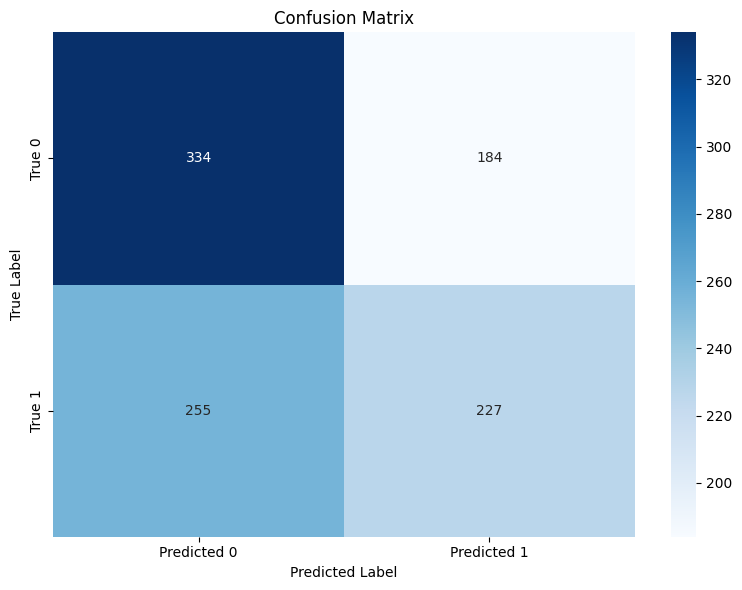

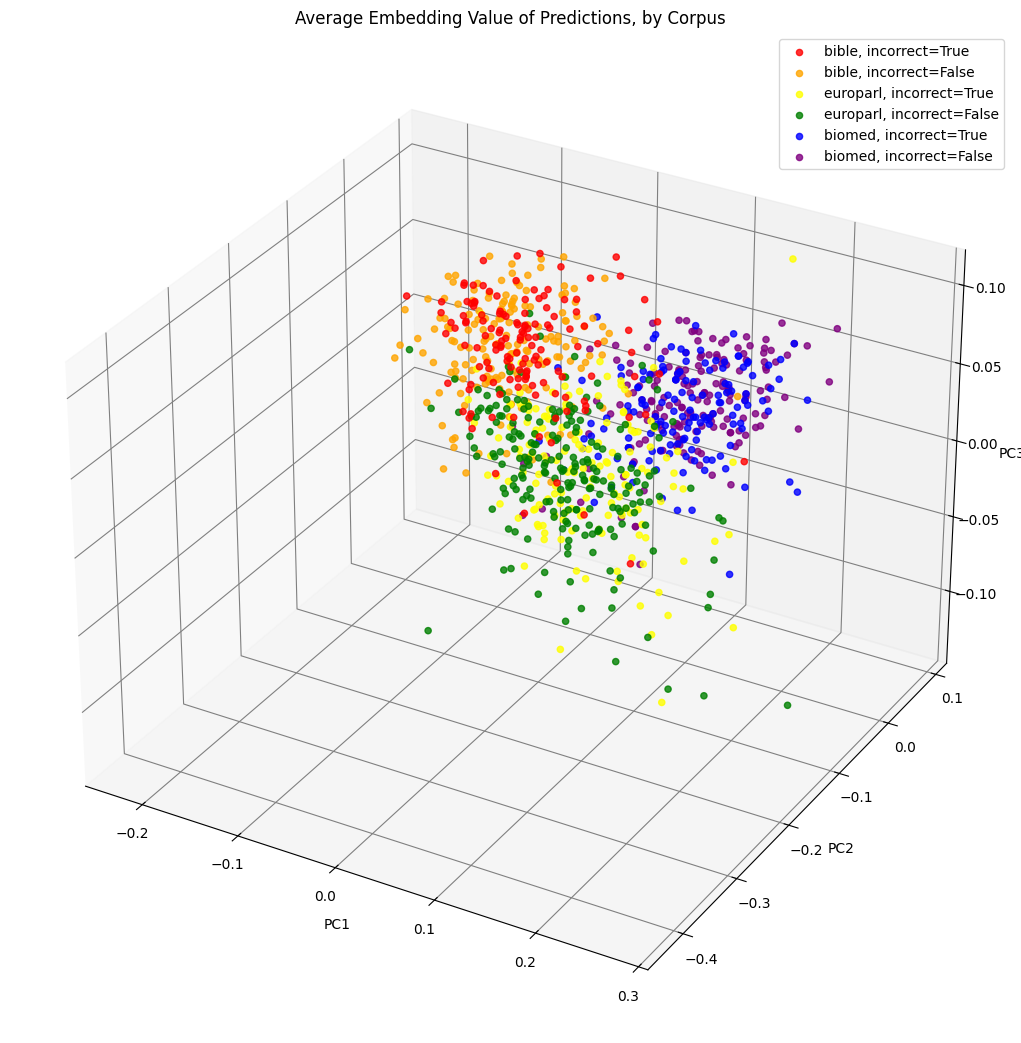


Frequency counts of corpus: corpus
europarl    374
biomed      316
bible       310
Name: count, dtype: int64

Counts of corpus in misclassified: corpus
europarl    157
biomed      141
bible       141
Name: count, dtype: int64

Counts of corpus in correctly classified: corpus
europarl    217
biomed      175
bible       169
Name: count, dtype: int64

Proportions of corpus in misclassified: corpus
europarl    0.357631
biomed      0.321185
bible       0.321185
Name: count, dtype: float64

Proportions of corpus in correctly classified: corpus
europarl    0.386809
biomed      0.311943
bible       0.301248
Name: count, dtype: float64
Subcorpus 'biomed' symmetric KL divergence: 3.244608891516798e-07
Subcorpus 'europarl' symmetric KL divergence: 5.228060469033662e-07
Subcorpus 'bible' symmetric KL divergence: 6.683676775615276e-07
model results saved


In [28]:
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
mismatch_indices = np.where(preds != true_labels)[0]

error_rows = []
for idx in mismatch_indices:
    text_value = df_test.iloc[idx][x_col]
    true_label_val = true_labels[idx]
    pred_label_val = preds[idx]

    error_rows.append({
        "hf_index": idx,
        "text": text_value,
        "true_label": true_label_val,
        "predicted_label": pred_label_val
    })

error_df = pd.DataFrame(error_rows)
df_test_for_merge = df_test.copy()
df_test_for_merge["error_matching_prefix"] = df_test_for_merge[x_col].str[:50]
# df_test_for_merge.drop(columns=[x_col], inplace=True)

error_df["error_matching_prefix"] = error_df["text"].str[:50]
error_df = error_df.merge(
    df_test_for_merge,
    on="error_matching_prefix",
    how="left",
    suffixes=("", "_source"))

error_df.to_csv("bert-base-cased_mismatches.csv", index=False)

# print("Number of misclassified samples:", len(error_df))
print("\nMerged error_df with extra columns:")
# display(error_df.head(15))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(true_labels, preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
#             xticklabels=["Predicted 0", "Predicted 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()
# print("confusion matrix metrics: \n", cm)
# error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
# error_df.to_csv(error_save_path, index=False)
# print("Result saved to results directory.")
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
df_test["true_label"] = true_labels
df_test["predicted_label"] = preds
df_test["is_incorrect"] = (df_test["predicted_label"] != df_test["true_label"])
df_test["avg_embedding"] = None
device = next(model.parameters()).device
for i in range(len(df_test)):
    text_value = df_test.iloc[i][x_col]
    e = tokenizer(text_value, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        emb = model.bert.embeddings.word_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
    df_test.at[i,"avg_embedding"] = emb
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=["Predicted 0","Predicted 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# print("confusion matrix metrics:\n", cm)

df_plot = df_test.dropna(subset=["avg_embedding"]).copy()
embeddings = np.stack(df_plot["avg_embedding"].values)
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)
df_plot["pca_x"] = reduced[:,0]
df_plot["pca_y"] = reduced[:,1]
df_plot["pca_z"] = reduced[:,2]
colors = {
    ("bible", True): "red",
    ("bible", False): "orange",
    ("europarl", True): "yellow",
    ("europarl", False): "green",
    ("biomed", True): "blue",
    ("biomed", False): "purple"}
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor("white")
ax.set_facecolor("white")
ax.xaxis._axinfo["grid"]["color"] = "gray"
ax.yaxis._axinfo["grid"]["color"] = "gray"
ax.zaxis._axinfo["grid"]["color"] = "gray"
for (corp, incorr), color in colors.items():
    subset = df_plot[(df_plot["corpus"]==corp) & (df_plot["is_incorrect"]==incorr)]
    ax.scatter(subset["pca_x"], subset["pca_y"], subset["pca_z"], c=color, s=20, alpha=0.8, label=f"{corp}, incorrect={incorr}")
ax.set_title("Average Embedding Value of Predictions, by Corpus", color="black")
ax.set_xlabel("PC1", color="black")
ax.set_ylabel("PC2", color="black")
ax.set_zlabel("PC3", color="black")
ax.legend(loc="best")
plt.show()
if "corpus" in df_test.columns:
    freqs = df_test["corpus"].value_counts()
    print("\nFrequency counts of corpus:", freqs)
    err_df = df_test[df_test["is_incorrect"]==True]
    corr_df = df_test[df_test["is_incorrect"]==False]
    err_counts = err_df["corpus"].value_counts()
    corr_counts = corr_df["corpus"].value_counts()
    print("\nCounts of corpus in misclassified:", err_counts)
    print("\nCounts of corpus in correctly classified:", corr_counts)
    print("\nProportions of corpus in misclassified:", err_counts/err_counts.sum())
    print("\nProportions of corpus in correctly classified:", corr_counts/corr_counts.sum())
    grouped_all = df_test.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_err = err_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_corr = corr_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    # print("\nAvg embedding of each subcorpus overall:", grouped_all)
    # print("\nAvg embedding of each subcorpus misclassified:", grouped_err)
    # print("\nAvg embedding of each subcorpus correctly classified:", grouped_corr)
err_stack = np.stack(df_test[df_test["is_incorrect"]==True]["avg_embedding"].values)
corr_stack = np.stack(df_test[df_test["is_incorrect"]==False]["avg_embedding"].values)
# print("\nAvg embedding of records predicted incorrectly:", err_stack.mean(axis=0))
# print("Avg embedding of records predicted correctly:", corr_stack.mean(axis=0))
error_df = df_test[df_test["is_incorrect"]==True].copy()
error_df.to_csv("misclassified_with_all_columns.csv", index=False)
error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
for corp in df_test["corpus"].unique():
    subset = df_test[df_test["corpus"]==corp]
    emb_true = subset[subset["is_incorrect"]==False]["avg_embedding"]
    emb_false = subset[subset["is_incorrect"]==True]["avg_embedding"]
    if len(emb_true)==0 or len(emb_false)==0:
        print(f"No valid data for subcorpus '{corp}'")
        continue
    p = np.mean(np.stack(emb_true.values), axis=0)
    q = np.mean(np.stack(emb_false.values), axis=0)
    p_exp = np.exp(p - np.max(p))
    q_exp = np.exp(q - np.max(q))
    p_sum = p_exp.sum()
    q_sum = q_exp.sum()
    if p_sum<=0 or q_sum<=0:
        print(f"Cannot form valid distributions for subcorpus '{corp}'")
        continue
    p_dist = p_exp / p_sum
    q_dist = q_exp / q_sum
    kl_pq = entropy(p_dist, q_dist)
    kl_qp = entropy(q_dist, p_dist)
    kl_sym = 0.5*(kl_pq + kl_qp)
    print(f"Subcorpus '{corp}' symmetric KL divergence: {kl_sym}")
error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
print("model results saved")

##### Result

### bert-large-cased


In [29]:
# Define Experiment Parameters
# named_model = "bert-base-cased"
# named_model = "roberta-base"
named_model = "bert-large-cased"
# named_model = "roberta-large"
# named_model = "" # modern bert
############
regularization_weight_decay = 0.5
learning_rate = 5e-6
size_batch = 128
length_max = 128
num_epochs = 1
##########################################
# x_col = "sentence"
x_col = "sentence_no_contractions"
# x_col = "pos_sequence"
# x_col = "dep_sequence"
# x_col = "morph_sequence"
# x_col = "snc_pos_seq"
# x_col = "snc_pos_alt"
# x_col = "snc_morph_seq"
# x_col = "snc_morph_alt"
# x_col = "snc_dep_seq"
# x_col = "snc_dep_alt"
# x_col = "snc_morph_complexity_value"
############
y_col = "binary_complexity"
# y_col = "complexity"
############
x_task = "single"
# x_task = "multi"
if x_task == "single":
    df_train = train_single_df
    df_val   = trial_val_single_df
    df_test  = test_single_df
else:
    df_train = train_multi_df
    df_val   = trial_val_multi_df
    df_test  = test_multi_df
##########################################
# Tokenize & Prepare Datasets
train_data_hf = prepare_dataset(
    df_train,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
val_data_hf = prepare_dataset(
    df_val,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
test_data_hf = prepare_dataset(
    df_test,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
print("Datasets prepared. Sample from train_data_hf:\n", train_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", val_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", test_data_hf[10])
##########################################
# custom_config = BertConfig.from_pretrained("roberta-base")
# custom_config.hidden_act = "gelu"  # alts: "relu" "silu"
# custom_config.attention_probs_dropout_prob = 0.1
# custom_config.hidden_dropout_prob = 0.1
# custom_config.gradient_checkpointing = False
##########################################
model, tokenizer = get_model_and_tokenizer(
    remote_model_name="bert-large-cased",
    local_model_path=None,
    config=None)
############
# model, tokenizer = get_model_and_tokenizer(
#     remote_model_name=None
#     local_model_path="...CONFIGURE_PATH...",
#     config=custom_config)
print("=============")
print(named_model, ":")
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters at load:", model.num_parameters(only_trainable=True))
print("=============")
print("model lineage:", MODEL_LINEAGE)
print("=============")

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Datasets prepared. Sample from train_data_hf:
 {'labels': tensor(0), 'input_ids': tensor([  101,  1130,  1864,   117,  1175,  1110,   170,  6145,  4423,  1103,
        10838,  1104,  1103,  1177,   118,  1270,  6298,  4692,   117,  1216,
         1112,  1343,  2272,  1106,  3750,   117,  1154,  1103,  1812,  7216,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert-large-cased :
num_parameters: 333581314
num_trainable_parameters at load: 333581314
model lineage: {'type': 'huggingface_hub', 'path': 'bert-large-cased', 'timestamp': '2025-04-14 01:55:08'}


In [30]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [31]:
for name, param in model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)

bert.embeddings.word_embeddings.weight requires_grad= True
bert.embeddings.position_embeddings.weight requires_grad= True
bert.embeddings.token_type_embeddings.weight requires_grad= True
bert.embeddings.LayerNorm.weight requires_grad= True
bert.embeddings.LayerNorm.bias requires_grad= True
bert.encoder.layer.0.attention.self.query.weight requires_grad= True
bert.encoder.layer.0.attention.self.query.bias requires_grad= True
bert.encoder.layer.0.attention.self.key.weight requires_grad= True
bert.encoder.layer.0.attention.self.key.bias requires_grad= True
bert.encoder.layer.0.attention.self.value.weight requires_grad= True
bert.encoder.layer.0.attention.self.value.bias requires_grad= True
bert.encoder.layer.0.attention.output.dense.weight requires_grad= True
bert.encoder.layer.0.attention.output.dense.bias requires_grad= True
bert.encoder.layer.0.attention.output.LayerNorm.weight requires_grad= True
bert.encoder.layer.0.attention.output.LayerNorm.bias requires_grad= True
bert.encoder.laye

In [32]:
##########################################
layers_to_unfreeze = [
    "bert.encoder.layer.23.",
    "bert.pooler.",
    "classifier.",
]
freeze_unfreeze_layers(model, layers_to_unfreeze=layers_to_unfreeze)
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))
print("=============")
##########################################
print("Experiment configuration used with this experiment:")
print("model used:", named_model)
print("learning rate used:", learning_rate)
print("number of epochs:", num_epochs)
print("maximum sequence length:", length_max)
print("batch size used:", size_batch)
print("regularization value:", regularization_weight_decay)
print("outcome variable:", y_col)
print("task:", x_task)
print("input column:", x_col)
##########################################
print("=============")
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

num_parameters: 333581314
num_trainable_parameters: 13647874
Experiment configuration used with this experiment:
model used: bert-la

In [33]:
model.resize_token_embeddings(len(tokenizer))

Embedding(28996, 1024, padding_idx=0)

In [34]:
for name, param in model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)

bert.embeddings.word_embeddings.weight requires_grad= False
bert.embeddings.position_embeddings.weight requires_grad= False
bert.embeddings.token_type_embeddings.weight requires_grad= False
bert.embeddings.LayerNorm.weight requires_grad= False
bert.embeddings.LayerNorm.bias requires_grad= False
bert.encoder.layer.0.attention.self.query.weight requires_grad= False
bert.encoder.layer.0.attention.self.query.bias requires_grad= False
bert.encoder.layer.0.attention.self.key.weight requires_grad= False
bert.encoder.layer.0.attention.self.key.bias requires_grad= False
bert.encoder.layer.0.attention.self.value.weight requires_grad= False
bert.encoder.layer.0.attention.self.value.bias requires_grad= False
bert.encoder.layer.0.attention.output.dense.weight requires_grad= False
bert.encoder.layer.0.attention.output.dense.bias requires_grad= False
bert.encoder.layer.0.attention.output.LayerNorm.weight requires_grad= False
bert.encoder.layer.0.attention.output.LayerNorm.bias requires_grad= False
be

In [35]:
model.resize_token_embeddings(len(tokenizer))

Embedding(28996, 1024, padding_idx=0)

In [36]:
# Train & Evaluate
trained_model, trainer_obj = train_transformer_model(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data_hf,
    val_dataset = val_data_hf,
    output_dir = dir_results,
    num_epochs = num_epochs,
    batch_size = size_batch,
    lr = learning_rate,
    weight_decay = regularization_weight_decay)
metrics = trainer_obj.evaluate()
print("Validation metrics:", metrics)
test_metrics = trainer_obj.evaluate(test_data_hf) if test_data_hf else None
print("Test metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5c1fb13bef41>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.728000,0.703056,0.530000,0.528571,0.230290,0.320809


Validation metrics: {'eval_loss': 0.7030557990074158, 'eval_accuracy': 0.53, 'eval_precision': 0.5285714285714286, 'eval_recall': 0.23029045643153526, 'eval_f1': 0.3208092485549133, 'eval_runtime': 9.3008, 'eval_samples_per_second': 107.517, 'eval_steps_per_second': 0.86, 'epoch': 1.0}
Test metrics: {'eval_loss': 0.7090029716491699, 'eval_accuracy': 0.518, 'eval_precision': 0.5, 'eval_recall': 0.1908713692946058, 'eval_f1': 0.27627627627627627, 'eval_runtime': 9.2893, 'eval_samples_per_second': 107.65, 'eval_steps_per_second': 0.861, 'epoch': 1.0}


In [37]:
# save model checkpoint
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pacific_time = datetime.now(zoneinfo.ZoneInfo("America/Los_Angeles"))
timestamp = pacific_time.isoformat()
model_save_path = os.path.join(dir_models, f"{x_task}_{named_model}_{y_col}_{timestamp}")
trainer_obj.save_model(model_save_path)
print(f"Model checkpoint saved to: {model_save_path}")
# log experiment results
experiment_info = {
    "model_name": named_model,
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": size_batch,
    "weight_decay": regularization_weight_decay,
    "x_task": x_task,
    "x_col": x_col,
    "y_col": y_col,
    "layers_to_unfreeze": layers_to_unfreeze}
model_info = gather_model_details(trained_model)
all_run_metrics = gather_all_run_metrics(
    trainer=trainer_obj,
    train_dataset=train_data_hf,
    val_dataset=val_data_hf,
    test_dataset=test_data_hf)
log_experiment_results_json(
    experiment_meta=experiment_info,
    model_details=model_info,
    run_metrics=all_run_metrics,
    log_file=log_filepath)
print(f"EXPERIMENT LOGGED TO: {log_filepath}")

Model checkpoint saved to: /content/drive/MyDrive/266-final/models/single_bert-large-cased_binary_complexity_2025-04-13T18:56:12.110652-07:00


EXPERIMENT LOGGED TO: /content/drive/MyDrive/266-final/results/experiment_runs.txt



Merged error_df with extra columns:


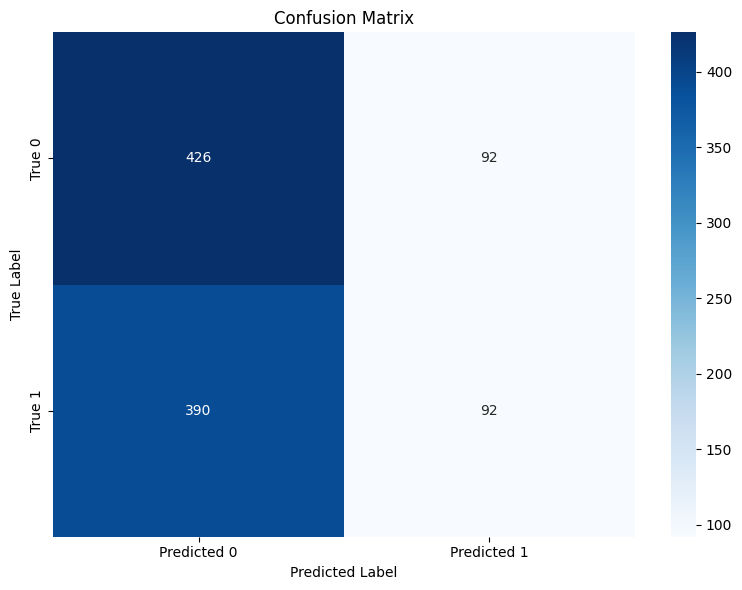

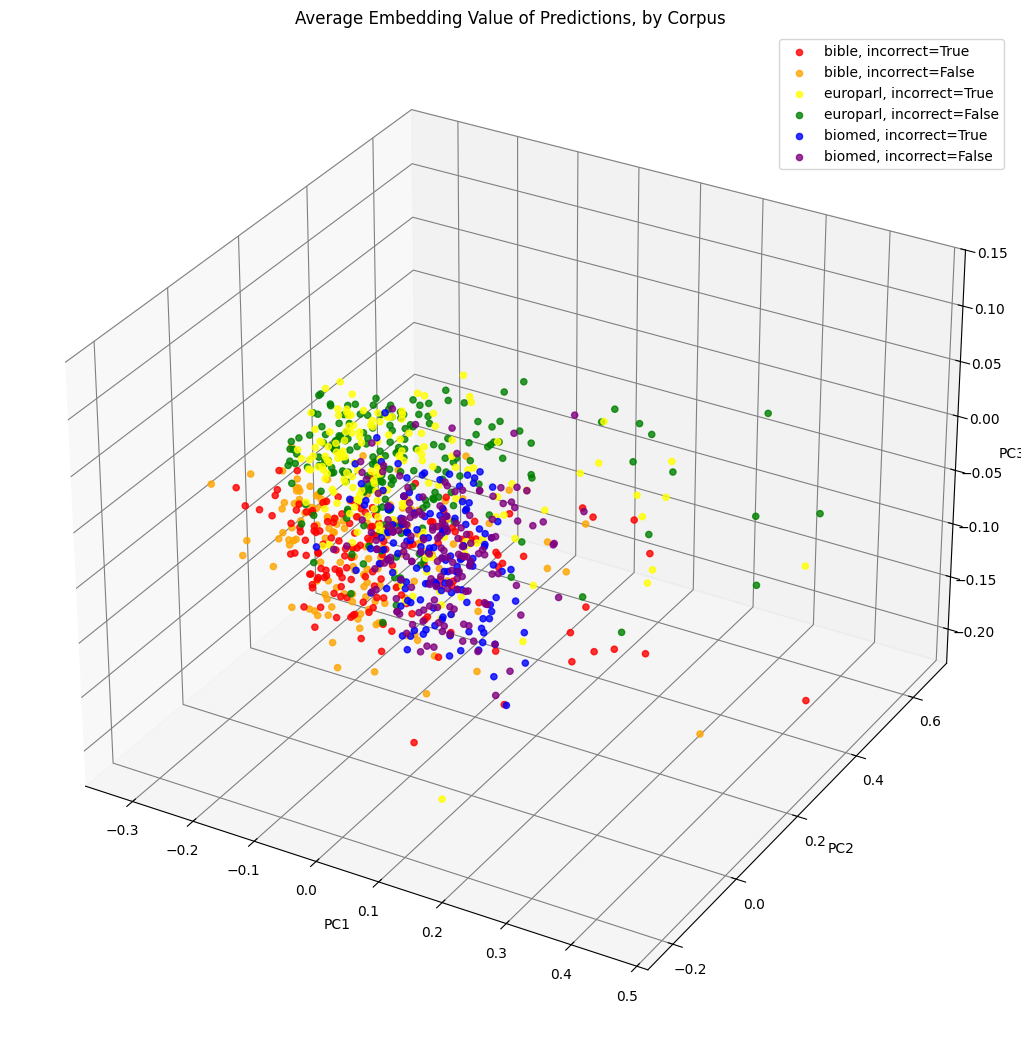


Frequency counts of corpus: corpus
europarl    374
biomed      316
bible       310
Name: count, dtype: int64

Counts of corpus in misclassified: corpus
europarl    172
bible       159
biomed      151
Name: count, dtype: int64

Counts of corpus in correctly classified: corpus
europarl    202
biomed      165
bible       151
Name: count, dtype: int64

Proportions of corpus in misclassified: corpus
europarl    0.356846
bible       0.329876
biomed      0.313278
Name: count, dtype: float64

Proportions of corpus in correctly classified: corpus
europarl    0.389961
biomed      0.318533
bible       0.291506
Name: count, dtype: float64
Subcorpus 'biomed' symmetric KL divergence: 2.593201681598221e-07
Subcorpus 'europarl' symmetric KL divergence: 4.6426749472826705e-07
Subcorpus 'bible' symmetric KL divergence: 6.619976385796855e-07
model results saved


In [38]:
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
mismatch_indices = np.where(preds != true_labels)[0]

error_rows = []
for idx in mismatch_indices:
    text_value = df_test.iloc[idx][x_col]
    true_label_val = true_labels[idx]
    pred_label_val = preds[idx]

    error_rows.append({
        "hf_index": idx,
        "text": text_value,
        "true_label": true_label_val,
        "predicted_label": pred_label_val
    })

error_df = pd.DataFrame(error_rows)
df_test_for_merge = df_test.copy()
df_test_for_merge["error_matching_prefix"] = df_test_for_merge[x_col].str[:50]
# df_test_for_merge.drop(columns=[x_col], inplace=True)

error_df["error_matching_prefix"] = error_df["text"].str[:50]
error_df = error_df.merge(
    df_test_for_merge,
    on="error_matching_prefix",
    how="left",
    suffixes=("", "_source"))

error_df.to_csv("bert-base-cased_mismatches.csv", index=False)

# print("Number of misclassified samples:", len(error_df))
print("\nMerged error_df with extra columns:")
# display(error_df.head(15))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(true_labels, preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
#             xticklabels=["Predicted 0", "Predicted 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()
# print("confusion matrix metrics: \n", cm)
# error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
# error_df.to_csv(error_save_path, index=False)
# print("Result saved to results directory.")
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
df_test["true_label"] = true_labels
df_test["predicted_label"] = preds
df_test["is_incorrect"] = (df_test["predicted_label"] != df_test["true_label"])
df_test["avg_embedding"] = None
device = next(model.parameters()).device
for i in range(len(df_test)):
    text_value = df_test.iloc[i][x_col]
    e = tokenizer(text_value, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        emb = model.bert.embeddings.word_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
    df_test.at[i,"avg_embedding"] = emb
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=["Predicted 0","Predicted 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# print("confusion matrix metrics:\n", cm)

df_plot = df_test.dropna(subset=["avg_embedding"]).copy()
embeddings = np.stack(df_plot["avg_embedding"].values)
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)
df_plot["pca_x"] = reduced[:,0]
df_plot["pca_y"] = reduced[:,1]
df_plot["pca_z"] = reduced[:,2]
colors = {
    ("bible", True): "red",
    ("bible", False): "orange",
    ("europarl", True): "yellow",
    ("europarl", False): "green",
    ("biomed", True): "blue",
    ("biomed", False): "purple"}
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor("white")
ax.set_facecolor("white")
ax.xaxis._axinfo["grid"]["color"] = "gray"
ax.yaxis._axinfo["grid"]["color"] = "gray"
ax.zaxis._axinfo["grid"]["color"] = "gray"
for (corp, incorr), color in colors.items():
    subset = df_plot[(df_plot["corpus"]==corp) & (df_plot["is_incorrect"]==incorr)]
    ax.scatter(subset["pca_x"], subset["pca_y"], subset["pca_z"], c=color, s=20, alpha=0.8, label=f"{corp}, incorrect={incorr}")
ax.set_title("Average Embedding Value of Predictions, by Corpus", color="black")
ax.set_xlabel("PC1", color="black")
ax.set_ylabel("PC2", color="black")
ax.set_zlabel("PC3", color="black")
ax.legend(loc="best")
plt.show()
if "corpus" in df_test.columns:
    freqs = df_test["corpus"].value_counts()
    print("\nFrequency counts of corpus:", freqs)
    err_df = df_test[df_test["is_incorrect"]==True]
    corr_df = df_test[df_test["is_incorrect"]==False]
    err_counts = err_df["corpus"].value_counts()
    corr_counts = corr_df["corpus"].value_counts()
    print("\nCounts of corpus in misclassified:", err_counts)
    print("\nCounts of corpus in correctly classified:", corr_counts)
    print("\nProportions of corpus in misclassified:", err_counts/err_counts.sum())
    print("\nProportions of corpus in correctly classified:", corr_counts/corr_counts.sum())
    grouped_all = df_test.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_err = err_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_corr = corr_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    # print("\nAvg embedding of each subcorpus overall:", grouped_all)
    # print("\nAvg embedding of each subcorpus misclassified:", grouped_err)
    # print("\nAvg embedding of each subcorpus correctly classified:", grouped_corr)
err_stack = np.stack(df_test[df_test["is_incorrect"]==True]["avg_embedding"].values)
corr_stack = np.stack(df_test[df_test["is_incorrect"]==False]["avg_embedding"].values)
# print("\nAvg embedding of records predicted incorrectly:", err_stack.mean(axis=0))
# print("Avg embedding of records predicted correctly:", corr_stack.mean(axis=0))
error_df = df_test[df_test["is_incorrect"]==True].copy()
error_df.to_csv("misclassified_with_all_columns.csv", index=False)
error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
for corp in df_test["corpus"].unique():
    subset = df_test[df_test["corpus"]==corp]
    emb_true = subset[subset["is_incorrect"]==False]["avg_embedding"]
    emb_false = subset[subset["is_incorrect"]==True]["avg_embedding"]
    if len(emb_true)==0 or len(emb_false)==0:
        print(f"No valid data for subcorpus '{corp}'")
        continue
    p = np.mean(np.stack(emb_true.values), axis=0)
    q = np.mean(np.stack(emb_false.values), axis=0)
    p_exp = np.exp(p - np.max(p))
    q_exp = np.exp(q - np.max(q))
    p_sum = p_exp.sum()
    q_sum = q_exp.sum()
    if p_sum<=0 or q_sum<=0:
        print(f"Cannot form valid distributions for subcorpus '{corp}'")
        continue
    p_dist = p_exp / p_sum
    q_dist = q_exp / q_sum
    kl_pq = entropy(p_dist, q_dist)
    kl_qp = entropy(q_dist, p_dist)
    kl_sym = 0.5*(kl_pq + kl_qp)
    print(f"Subcorpus '{corp}' symmetric KL divergence: {kl_sym}")
error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
print("model results saved")

##### Result

### answerdotai/ModernBERT-base


In [39]:
# Define Experiment Parameters
# named_model = "bert-base-cased"
# named_model = "roberta-base"
# named_model = "bert-large-cased"
# named_model = "roberta-large"
named_model = "answerdotai/ModernBERT-base" # modern bert
############
regularization_weight_decay = 0.5
learning_rate = 5e-6
size_batch = 128
length_max = 128
num_epochs = 1
##########################################
# x_col = "sentence"
x_col = "sentence_no_contractions"
# x_col = "pos_sequence"
# x_col = "dep_sequence"
# x_col = "morph_sequence"
# x_col = "snc_pos_seq"
# x_col = "snc_pos_alt"
# x_col = "snc_morph_seq"
# x_col = "snc_morph_alt"
# x_col = "snc_dep_seq"
# x_col = "snc_dep_alt"
# x_col = "snc_morph_complexity_value"
############
y_col = "binary_complexity"
# y_col = "complexity"
############
x_task = "single"
# x_task = "multi"
if x_task == "single":
    df_train = train_single_df
    df_val   = trial_val_single_df
    df_test  = test_single_df
else:
    df_train = train_multi_df
    df_val   = trial_val_multi_df
    df_test  = test_multi_df
##########################################
# Tokenize & Prepare Datasets
train_data_hf = prepare_dataset(
    df_train,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
val_data_hf = prepare_dataset(
    df_val,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
test_data_hf = prepare_dataset(
    df_test,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
print("Datasets prepared. Sample from train_data_hf:\n", train_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", val_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", test_data_hf[10])
##########################################
# custom_config = BertConfig.from_pretrained("roberta-base")
# custom_config.hidden_act = "gelu"  # alts: "relu" "silu"
# custom_config.attention_probs_dropout_prob = 0.1
# custom_config.hidden_dropout_prob = 0.1
# custom_config.gradient_checkpointing = False
##########################################
model, tokenizer = get_model_and_tokenizer(
    remote_model_name="answerdotai/ModernBERT-base",
    local_model_path=None,
    config=None)
############
# model, tokenizer = get_model_and_tokenizer(
#     remote_model_name=None
#     local_model_path="...CONFIGURE_PATH...",
#     config=custom_config)
print("=============")
print(named_model, ":")
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters at load:", model.num_parameters(only_trainable=True))
print("=============")
print("model lineage:", MODEL_LINEAGE)
print("=============")

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Datasets prepared. Sample from train_data_hf:
 {'labels': tensor(0), 'input_ids': tensor([  101,  1130,  1864,   117,  1175,  1110,   170,  6145,  4423,  1103,
        10838,  1104,  1103,  1177,   118,  1270,  6298,  4692,   117,  1216,
         1112,  1343,  2272,  1106,  3750,   117,  1154,  1103,  1812,  7216,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


answerdotai/ModernBERT-base :
num_parameters: 149606402
num_trainable_parameters at load: 149606402
model lineage: {'type': 'huggingface_hub', 'path': 'answerdotai/ModernBERT-base', 'timestamp': '2025-04-14 01:57:37'}


In [40]:
print(model)

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [41]:
for name, param in model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)

model.embeddings.tok_embeddings.weight requires_grad= True
model.embeddings.norm.weight requires_grad= True
model.layers.0.attn.Wqkv.weight requires_grad= True
model.layers.0.attn.Wo.weight requires_grad= True
model.layers.0.mlp_norm.weight requires_grad= True
model.layers.0.mlp.Wi.weight requires_grad= True
model.layers.0.mlp.Wo.weight requires_grad= True
model.layers.1.attn_norm.weight requires_grad= True
model.layers.1.attn.Wqkv.weight requires_grad= True
model.layers.1.attn.Wo.weight requires_grad= True
model.layers.1.mlp_norm.weight requires_grad= True
model.layers.1.mlp.Wi.weight requires_grad= True
model.layers.1.mlp.Wo.weight requires_grad= True
model.layers.2.attn_norm.weight requires_grad= True
model.layers.2.attn.Wqkv.weight requires_grad= True
model.layers.2.attn.Wo.weight requires_grad= True
model.layers.2.mlp_norm.weight requires_grad= True
model.layers.2.mlp.Wi.weight requires_grad= True
model.layers.2.mlp.Wo.weight requires_grad= True
model.layers.3.attn_norm.weight req

In [42]:
# Inspect the attention_mask tensor for the first few samples
for i in range(5):
    print(train_data_hf[i]['attention_mask'])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [43]:
##########################################
layers_to_unfreeze = [
    "model.layers.21.attn_norm.weight",
    "model.layers.21.attn.Wqkv.weight",
    "model.layers.21.attn.Wo.weight",
    "model.layers.21.mlp_norm.weight",
    "model.layers.21.mlp.Wi.weight",
    "model.layers.21.mlp.Wo.weight",
    "model.final_norm.weight",
    "head.dense.weight",
    "head.norm.weight",
    "classifier.weight",
    "classifier.bias"]
freeze_unfreeze_layers(model, layers_to_unfreeze=layers_to_unfreeze)
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))
print("=============")
##########################################
print("Experiment configuration used with this experiment:")
print("model used:", named_model)
print("learning rate used:", learning_rate)
print("number of epochs:", num_epochs)
print("maximum sequence length:", length_max)
print("batch size used:", size_batch)
print("regularization value:", regularization_weight_decay)
print("outcome variable:", y_col)
print("task:", x_task)
print("input column:", x_col)
##########################################
print("=============")
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))

ModernBertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "global_rope_theta": 160000.0,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 768,
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 1152,
  "layer_norm_eps": 1e-05,
  "local_attention": 128,
  "local_rope_theta": 10000.0,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "mlp_dropout": 0.0,
  "model_type": "modernbert",
  "norm_bias": false,
  "norm_eps": 1e-05,
  "num_attention_heads": 12,
  "num_hidden_layers": 22,
  "

In [44]:
for name, param in model.named_parameters():
    print(name, "requires_grad=", param.requires_grad)

model.embeddings.tok_embeddings.weight requires_grad= False
model.embeddings.norm.weight requires_grad= False
model.layers.0.attn.Wqkv.weight requires_grad= False
model.layers.0.attn.Wo.weight requires_grad= False
model.layers.0.mlp_norm.weight requires_grad= False
model.layers.0.mlp.Wi.weight requires_grad= False
model.layers.0.mlp.Wo.weight requires_grad= False
model.layers.1.attn_norm.weight requires_grad= False
model.layers.1.attn.Wqkv.weight requires_grad= False
model.layers.1.attn.Wo.weight requires_grad= False
model.layers.1.mlp_norm.weight requires_grad= False
model.layers.1.mlp.Wi.weight requires_grad= False
model.layers.1.mlp.Wo.weight requires_grad= False
model.layers.2.attn_norm.weight requires_grad= False
model.layers.2.attn.Wqkv.weight requires_grad= False
model.layers.2.attn.Wo.weight requires_grad= False
model.layers.2.mlp_norm.weight requires_grad= False
model.layers.2.mlp.Wi.weight requires_grad= False
model.layers.2.mlp.Wo.weight requires_grad= False
model.layers.3.a

In [45]:
# model.resize_token_embeddings(len(tokenizer))

In [46]:
# Train & Evaluate
trained_model, trainer_obj = train_transformer_model(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data_hf,
    val_dataset = val_data_hf,
    output_dir = dir_results,
    num_epochs = num_epochs,
    batch_size = size_batch,
    lr = learning_rate,
    weight_decay = regularization_weight_decay)
metrics = trainer_obj.evaluate()
print("Validation metrics:", metrics)
test_metrics = trainer_obj.evaluate(test_data_hf) if test_data_hf else None
print("Test metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5c1fb13bef41>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.868900,0.808815,0.507000,0.488660,0.491701,0.490176


Validation metrics: {'eval_loss': 0.8088154792785645, 'eval_accuracy': 0.507, 'eval_precision': 0.488659793814433, 'eval_recall': 0.491701244813278, 'eval_f1': 0.4901758014477766, 'eval_runtime': 7.2048, 'eval_samples_per_second': 138.797, 'eval_steps_per_second': 1.11, 'epoch': 1.0}
Test metrics: {'eval_loss': 0.8201115727424622, 'eval_accuracy': 0.515, 'eval_precision': 0.49700598802395207, 'eval_recall': 0.516597510373444, 'eval_f1': 0.5066124109867752, 'eval_runtime': 7.3626, 'eval_samples_per_second': 135.821, 'eval_steps_per_second': 1.087, 'epoch': 1.0}


In [47]:
# save model checkpoint
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pacific_time = datetime.now(zoneinfo.ZoneInfo("America/Los_Angeles"))
timestamp = pacific_time.isoformat()
model_save_path = os.path.join(dir_models, f"{x_task}_{named_model}_{y_col}_{timestamp}")
trainer_obj.save_model(model_save_path)
print(f"Model checkpoint saved to: {model_save_path}")
# log experiment results
experiment_info = {
    "model_name": named_model,
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": size_batch,
    "weight_decay": regularization_weight_decay,
    "x_task": x_task,
    "x_col": x_col,
    "y_col": y_col,
    "layers_to_unfreeze": layers_to_unfreeze}
model_info = gather_model_details(trained_model)
all_run_metrics = gather_all_run_metrics(
    trainer=trainer_obj,
    train_dataset=train_data_hf,
    val_dataset=val_data_hf,
    test_dataset=test_data_hf)
log_experiment_results_json(
    experiment_meta=experiment_info,
    model_details=model_info,
    run_metrics=all_run_metrics,
    log_file=log_filepath)
print(f"EXPERIMENT LOGGED TO: {log_filepath}")

Model checkpoint saved to: /content/drive/MyDrive/266-final/models/single_answerdotai/ModernBERT-base_binary_complexity_2025-04-13T18:58:22.859158-07:00


EXPERIMENT LOGGED TO: /content/drive/MyDrive/266-final/results/experiment_runs.txt



Merged error_df with extra columns:


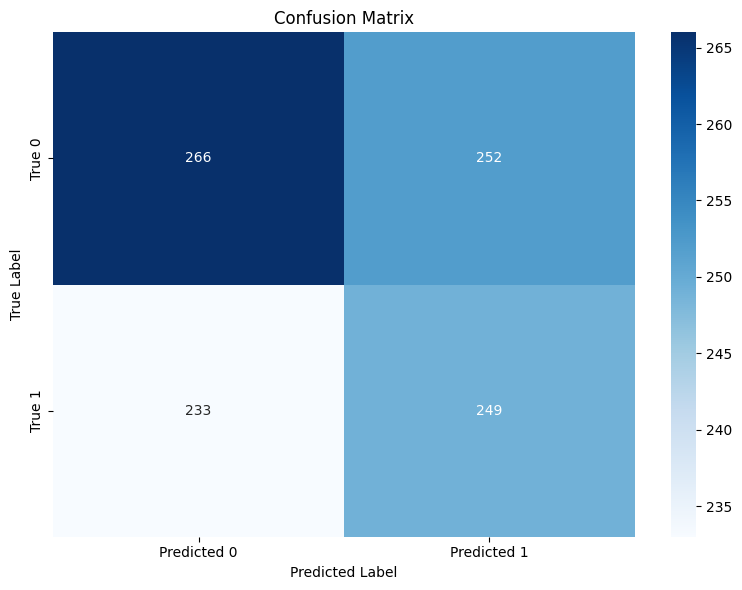

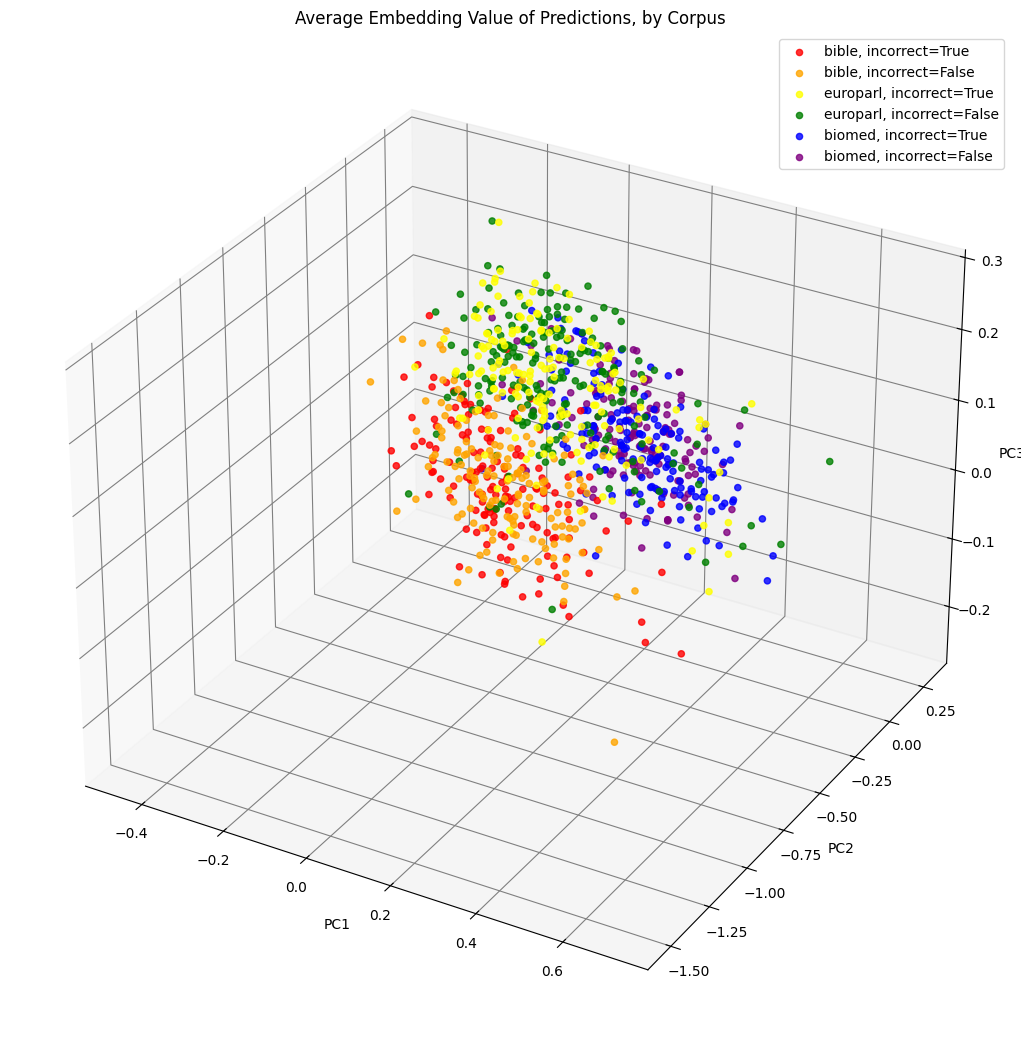


Frequency counts of corpus: corpus
europarl    374
biomed      316
bible       310
Name: count, dtype: int64

Counts of corpus in misclassified: corpus
europarl    168
biomed      159
bible       158
Name: count, dtype: int64

Counts of corpus in correctly classified: corpus
europarl    206
biomed      157
bible       152
Name: count, dtype: int64

Proportions of corpus in misclassified: corpus
europarl    0.346392
biomed      0.327835
bible       0.325773
Name: count, dtype: float64

Proportions of corpus in correctly classified: corpus
europarl    0.400000
biomed      0.304854
bible       0.295146
Name: count, dtype: float64
Subcorpus 'biomed' symmetric KL divergence: 1.8457217644529404e-06
Subcorpus 'europarl' symmetric KL divergence: 1.4357515857590244e-06
Subcorpus 'bible' symmetric KL divergence: 1.6860511154101313e-06
model results saved


In [48]:
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
mismatch_indices = np.where(preds != true_labels)[0]

error_rows = []
for idx in mismatch_indices:
    text_value = df_test.iloc[idx][x_col]
    true_label_val = true_labels[idx]
    pred_label_val = preds[idx]

    error_rows.append({
        "hf_index": idx,
        "text": text_value,
        "true_label": true_label_val,
        "predicted_label": pred_label_val
    })

error_df = pd.DataFrame(error_rows)
df_test_for_merge = df_test.copy()
df_test_for_merge["error_matching_prefix"] = df_test_for_merge[x_col].str[:50]
# df_test_for_merge.drop(columns=[x_col], inplace=True)

error_df["error_matching_prefix"] = error_df["text"].str[:50]
error_df = error_df.merge(
    df_test_for_merge,
    on="error_matching_prefix",
    how="left",
    suffixes=("", "_source"))

error_df.to_csv("bert-base-cased_mismatches.csv", index=False)

# print("Number of misclassified samples:", len(error_df))
print("\nMerged error_df with extra columns:")
# display(error_df.head(15))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(true_labels, preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
#             xticklabels=["Predicted 0", "Predicted 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()
# print("confusion matrix metrics: \n", cm)
# error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
# error_df.to_csv(error_save_path, index=False)
# print("Result saved to results directory.")
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
df_test["true_label"] = true_labels
df_test["predicted_label"] = preds
df_test["is_incorrect"] = (df_test["predicted_label"] != df_test["true_label"])
df_test["avg_embedding"] = None
device = next(model.parameters()).device
for i in range(len(df_test)):
    text_value = df_test.iloc[i][x_col]
    e = tokenizer(text_value, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        # emb = model.bert.embeddings.word_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
        emb = model.model.embeddings.tok_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
    df_test.at[i,"avg_embedding"] = emb
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=["Predicted 0","Predicted 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# print("confusion matrix metrics:\n", cm)

df_plot = df_test.dropna(subset=["avg_embedding"]).copy()
embeddings = np.stack(df_plot["avg_embedding"].values)
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)
df_plot["pca_x"] = reduced[:,0]
df_plot["pca_y"] = reduced[:,1]
df_plot["pca_z"] = reduced[:,2]
colors = {
    ("bible", True): "red",
    ("bible", False): "orange",
    ("europarl", True): "yellow",
    ("europarl", False): "green",
    ("biomed", True): "blue",
    ("biomed", False): "purple"}
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor("white")
ax.set_facecolor("white")
ax.xaxis._axinfo["grid"]["color"] = "gray"
ax.yaxis._axinfo["grid"]["color"] = "gray"
ax.zaxis._axinfo["grid"]["color"] = "gray"
for (corp, incorr), color in colors.items():
    subset = df_plot[(df_plot["corpus"]==corp) & (df_plot["is_incorrect"]==incorr)]
    ax.scatter(subset["pca_x"], subset["pca_y"], subset["pca_z"], c=color, s=20, alpha=0.8, label=f"{corp}, incorrect={incorr}")
ax.set_title("Average Embedding Value of Predictions, by Corpus", color="black")
ax.set_xlabel("PC1", color="black")
ax.set_ylabel("PC2", color="black")
ax.set_zlabel("PC3", color="black")
ax.legend(loc="best")
plt.show()
if "corpus" in df_test.columns:
    freqs = df_test["corpus"].value_counts()
    print("\nFrequency counts of corpus:", freqs)
    err_df = df_test[df_test["is_incorrect"]==True]
    corr_df = df_test[df_test["is_incorrect"]==False]
    err_counts = err_df["corpus"].value_counts()
    corr_counts = corr_df["corpus"].value_counts()
    print("\nCounts of corpus in misclassified:", err_counts)
    print("\nCounts of corpus in correctly classified:", corr_counts)
    print("\nProportions of corpus in misclassified:", err_counts/err_counts.sum())
    print("\nProportions of corpus in correctly classified:", corr_counts/corr_counts.sum())
    grouped_all = df_test.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_err = err_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_corr = corr_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    # print("\nAvg embedding of each subcorpus overall:", grouped_all)
    # print("\nAvg embedding of each subcorpus misclassified:", grouped_err)
    # print("\nAvg embedding of each subcorpus correctly classified:", grouped_corr)
err_stack = np.stack(df_test[df_test["is_incorrect"]==True]["avg_embedding"].values)
corr_stack = np.stack(df_test[df_test["is_incorrect"]==False]["avg_embedding"].values)
# print("\nAvg embedding of records predicted incorrectly:", err_stack.mean(axis=0))
# print("Avg embedding of records predicted correctly:", corr_stack.mean(axis=0))
error_df = df_test[df_test["is_incorrect"]==True].copy()
# error_df.to_csv("misclassified_with_all_columns.csv", index=False)
# error_save_path = os.path.join(dir_results, f"{x_task}_modernbert-base_{y_col}_{x_col}_errors.csv")
# df_test.to_csv(error_save_path, index=False)
for corp in df_test["corpus"].unique():
    subset = df_test[df_test["corpus"]==corp]
    emb_true = subset[subset["is_incorrect"]==False]["avg_embedding"]
    emb_false = subset[subset["is_incorrect"]==True]["avg_embedding"]
    if len(emb_true)==0 or len(emb_false)==0:
        print(f"No valid data for subcorpus '{corp}'")
        continue
    p = np.mean(np.stack(emb_true.values), axis=0)
    q = np.mean(np.stack(emb_false.values), axis=0)
    p_exp = np.exp(p - np.max(p))
    q_exp = np.exp(q - np.max(q))
    p_sum = p_exp.sum()
    q_sum = q_exp.sum()
    if p_sum<=0 or q_sum<=0:
        print(f"Cannot form valid distributions for subcorpus '{corp}'")
        continue
    p_dist = p_exp / p_sum
    q_dist = q_exp / q_sum
    kl_pq = entropy(p_dist, q_dist)
    kl_qp = entropy(q_dist, p_dist)
    kl_sym = 0.5*(kl_pq + kl_qp)
    print(f"Subcorpus '{corp}' symmetric KL divergence: {kl_sym}")
error_save_path = os.path.join(dir_results, f"{x_task}_modernbert-large_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
print("model results saved")

##### Result

### answerdotai/ModernBERT-large


In [49]:
# Define Experiment Parameters
# named_model = "bert-base-cased"
# named_model = "roberta-base"
# named_model = "bert-large-cased"
# named_model = "roberta-large"
named_model = "answerdotai/ModernBERT-large" # modern bert
############
regularization_weight_decay = 0.5
learning_rate = 5e-6
size_batch = 128
length_max = 128
num_epochs = 1
##########################################
# x_col = "sentence"
x_col = "sentence_no_contractions"
# x_col = "pos_sequence"
# x_col = "dep_sequence"
# x_col = "morph_sequence"
# x_col = "snc_pos_seq"
# x_col = "snc_pos_alt"
# x_col = "snc_morph_seq"
# x_col = "snc_morph_alt"
# x_col = "snc_dep_seq"
# x_col = "snc_dep_alt"
# x_col = "snc_morph_complexity_value"
############
y_col = "binary_complexity"
# y_col = "complexity"
############
x_task = "single"
# x_task = "multi"
if x_task == "single":
    df_train = train_single_df
    df_val   = trial_val_single_df
    df_test  = test_single_df
else:
    df_train = train_multi_df
    df_val   = trial_val_multi_df
    df_test  = test_multi_df
##########################################
# Tokenize & Prepare Datasets
train_data_hf = prepare_dataset(
    df_train,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
val_data_hf = prepare_dataset(
    df_val,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
test_data_hf = prepare_dataset(
    df_test,
    tokenizer,
    text_col=x_col,
    label_col=y_col,
    max_length=length_max)
print("Datasets prepared. Sample from train_data_hf:\n", train_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", val_data_hf[10])
# print("Datasets prepared. Sample from train_data_hf:\n", test_data_hf[10])
##########################################
model, tokenizer = get_model_and_tokenizer(
    remote_model_name="answerdotai/ModernBERT-large",
    local_model_path=None,
    config=None)
############
# model, tokenizer = get_model_and_tokenizer(
#     remote_model_name=None
#     local_model_path="...CONFIGURE_PATH...",
#     config=custom_config)
##########################################
print("=============")
print(named_model, ":")
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters at load:", model.num_parameters(only_trainable=True))
print("=============")
print("model lineage:", MODEL_LINEAGE)
print("=============")

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Datasets prepared. Sample from train_data_hf:
 {'labels': tensor(0), 'input_ids': tensor([50281,   688,   958,    13,   627,   310,   247,  5955,  5001,   253,
        11250,   273,   253,   594,    14,  8890,  6024,  4815,    13,   824,
          347,  1110,  2905,   281,  3126,    13,   715,   253,  3971,  9801,
           15, 50282, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
        50283, 50283, 50283, 50283, 50283, 50283, 50283, 502

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


answerdotai/ModernBERT-large :
num_parameters: 395833346
num_trainable_parameters at load: 395833346
model lineage: {'type': 'huggingface_hub', 'path': 'answerdotai/ModernBERT-large', 'timestamp': '2025-04-14 01:59:20'}


In [50]:
print(model)

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 1024, padding_idx=50283)
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=1024, out_features=3072, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=1024, out_features=1024, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=1024, out_features=5248, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=2624, out_features=1024, bias=False)
        

In [51]:
# for name, param in model.named_parameters():
#     print(name, "requires_grad=", param.requires_grad)

In [52]:
# # Inspect the attention_mask tensor for the first few samples
# for i in range(5):
#     print(train_data_hf[i]['attention_mask'])

In [53]:
##########################################
layers_to_unfreeze = [
    "model.layers.27.attn_norm.weight",
    "model.layers.27.attn.Wqkv.weight",
    "model.layers.27.attn.Wo.weight",
    "model.layers.27.mlp_norm.weight",
    "model.layers.27.mlp.Wi.weight",
    "model.layers.27.mlp.Wo.weight",
    "model.final_norm.weight",
    "head.dense.weight",
    "head.norm.weight",
    "classifier.weight",
    "classifier.bias"
    ]
freeze_unfreeze_layers(model, layers_to_unfreeze=layers_to_unfreeze)
print(model.config)
print("=============")
print("num_parameters:", model.num_parameters())
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))
print("=============")
##########################################
print("Experiment configuration used with this experiment:")
print("model used:", named_model)
print("learning rate used:", learning_rate)
print("number of epochs:", num_epochs)
print("maximum sequence length:", length_max)
print("batch size used:", size_batch)
print("regularization value:", regularization_weight_decay)
print("outcome variable:", y_col)
print("task:", x_task)
print("input column:", x_col)
##########################################
print("=============")
print("num_trainable_parameters:", model.num_parameters(only_trainable=True))

ModernBertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "global_rope_theta": 160000.0,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 1024,
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 2624,
  "layer_norm_eps": 1e-05,
  "local_attention": 128,
  "local_rope_theta": 10000.0,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "mlp_dropout": 0.0,
  "model_type": "modernbert",
  "norm_bias": false,
  "norm_eps": 1e-05,
  "num_attention_heads": 16,
  "num_hidden_layers": 28,
  

In [54]:
# for name, param in model.named_parameters():
#     print(name, "requires_grad=", param.requires_grad)

In [55]:
# model.resize_token_embeddings(len(tokenizer))

In [56]:
# Train & Evaluate
trained_model, trainer_obj = train_transformer_model(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_data_hf,
    val_dataset = val_data_hf,
    output_dir = dir_results,
    num_epochs = num_epochs,
    batch_size = size_batch,
    lr = learning_rate,
    weight_decay = regularization_weight_decay)
metrics = trainer_obj.evaluate()
print("Validation metrics:", metrics)
test_metrics = trainer_obj.evaluate(test_data_hf) if test_data_hf else None
print("Test metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5c1fb13bef41>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.720400,0.697760,0.543000,0.526427,0.516598,0.521466


W0414 02:00:03.633000 16195 torch/_dynamo/convert_frame.py:906] [1/8] torch._dynamo hit config.cache_size_limit (8)
W0414 02:00:03.633000 16195 torch/_dynamo/convert_frame.py:906] [1/8]    function: 'compiled_mlp' (/usr/local/lib/python3.11/dist-packages/transformers/models/modernbert/modeling_modernbert.py:552)
W0414 02:00:03.633000 16195 torch/_dynamo/convert_frame.py:906] [1/8]    last reason: 1/0: GLOBAL_STATE changed: grad_mode 
W0414 02:00:03.633000 16195 torch/_dynamo/convert_frame.py:906] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0414 02:00:03.633000 16195 torch/_dynamo/convert_frame.py:906] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation metrics: {'eval_loss': 0.697759747505188, 'eval_accuracy': 0.543, 'eval_precision': 0.5264270613107822, 'eval_recall': 0.516597510373444, 'eval_f1': 0.5214659685863874, 'eval_runtime': 10.3218, 'eval_samples_per_second': 96.882, 'eval_steps_per_second': 0.775, 'epoch': 1.0}
Test metrics: {'eval_loss': 0.7167285084724426, 'eval_accuracy': 0.512, 'eval_precision': 0.4936708860759494, 'eval_recall': 0.4854771784232365, 'eval_f1': 0.4895397489539749, 'eval_runtime': 10.9373, 'eval_samples_per_second': 91.431, 'eval_steps_per_second': 0.731, 'epoch': 1.0}


In [57]:
# save model checkpoint
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = os.path.join(dir_models, f"{x_task}_{named_model}_{y_col}_{timestamp}")
trainer_obj.save_model(model_save_path)
print(f"Model checkpoint saved to: {model_save_path}")
# log experiment results
experiment_info = {
    "model_name": named_model,
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": size_batch,
    "weight_decay": regularization_weight_decay,
    "x_task": x_task,
    "x_col": x_col,
    "y_col": y_col,
    "layers_to_unfreeze": layers_to_unfreeze}
model_info = gather_model_details(trained_model)
all_run_metrics = gather_all_run_metrics(
    trainer=trainer_obj,
    train_dataset=train_data_hf,
    val_dataset=val_data_hf,
    test_dataset=test_data_hf)
log_experiment_results_json(
    experiment_meta=experiment_info,
    model_details=model_info,
    run_metrics=all_run_metrics,
    log_file=log_filepath)
print(f"EXPERIMENT LOGGED TO: {log_filepath}")

Model checkpoint saved to: /content/drive/MyDrive/266-final/models/single_answerdotai/ModernBERT-large_binary_complexity_20250414_020035


EXPERIMENT LOGGED TO: /content/drive/MyDrive/266-final/results/experiment_runs.txt



Merged error_df with extra columns:


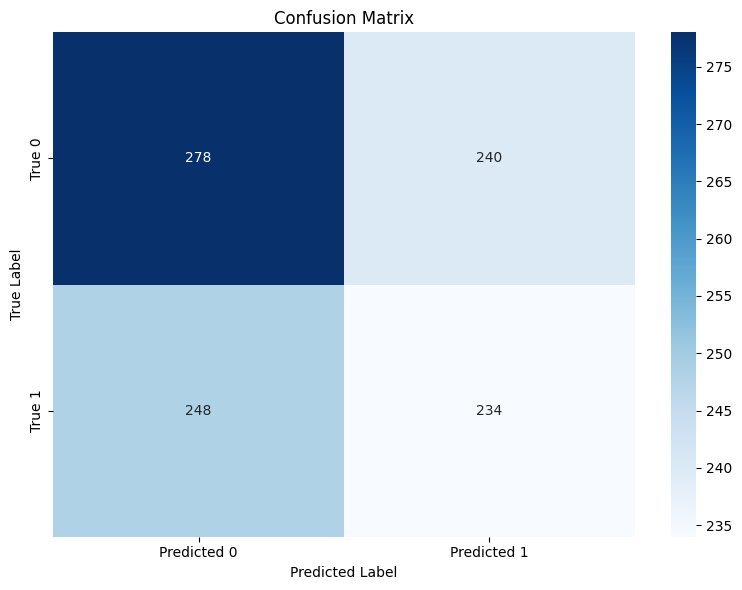

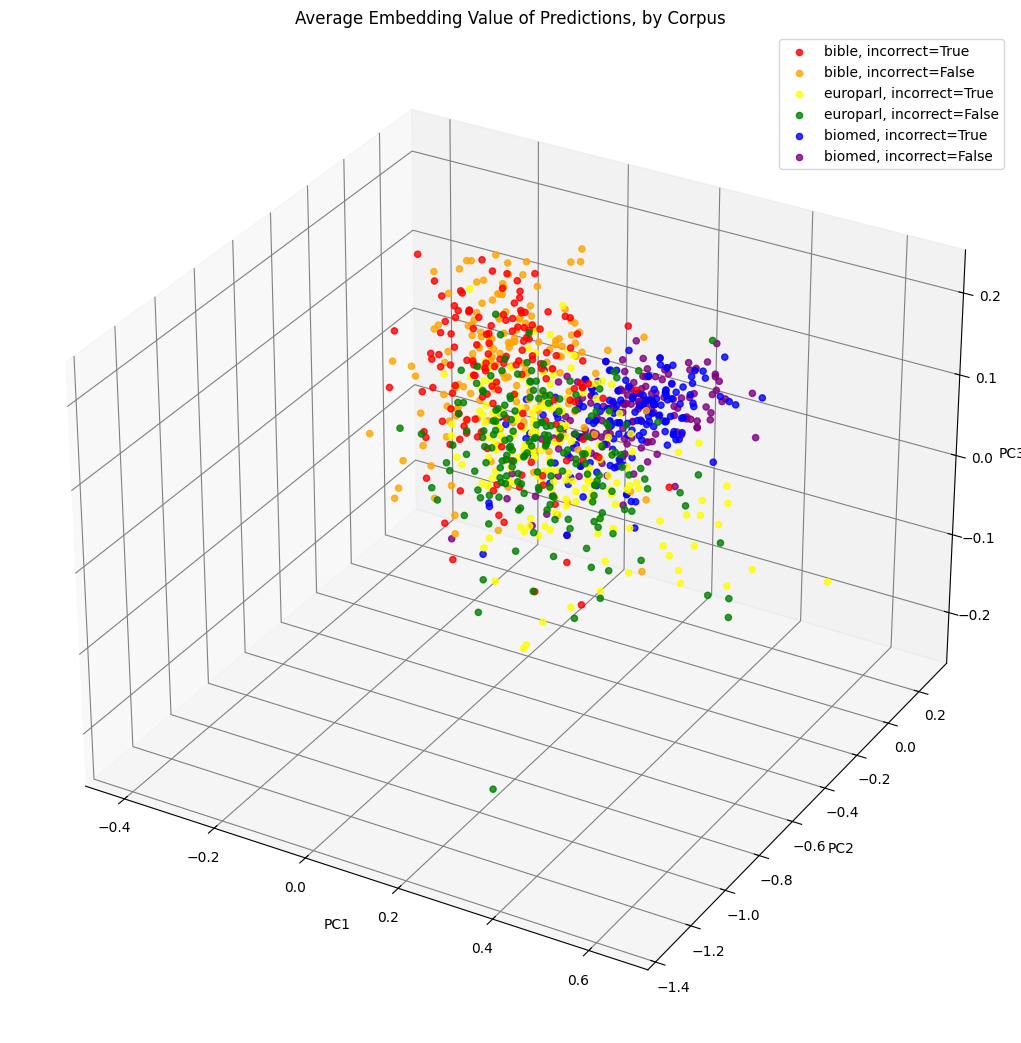


Frequency counts of corpus: corpus
europarl    374
biomed      316
bible       310
Name: count, dtype: int64

Counts of corpus in misclassified: corpus
europarl    185
biomed      152
bible       151
Name: count, dtype: int64

Counts of corpus in correctly classified: corpus
europarl    189
biomed      164
bible       159
Name: count, dtype: int64

Proportions of corpus in misclassified: corpus
europarl    0.379098
biomed      0.311475
bible       0.309426
Name: count, dtype: float64

Proportions of corpus in correctly classified: corpus
europarl    0.369141
biomed      0.320312
bible       0.310547
Name: count, dtype: float64
Subcorpus 'biomed' symmetric KL divergence: 8.158935155510512e-07
Subcorpus 'europarl' symmetric KL divergence: 9.710584787971171e-07
Subcorpus 'bible' symmetric KL divergence: 1.1354024662615837e-06
model results saved


In [58]:
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
mismatch_indices = np.where(preds != true_labels)[0]

error_rows = []
for idx in mismatch_indices:
    text_value = df_test.iloc[idx][x_col]
    true_label_val = true_labels[idx]
    pred_label_val = preds[idx]

    error_rows.append({
        "hf_index": idx,
        "text": text_value,
        "true_label": true_label_val,
        "predicted_label": pred_label_val
    })

error_df = pd.DataFrame(error_rows)
df_test_for_merge = df_test.copy()
df_test_for_merge["error_matching_prefix"] = df_test_for_merge[x_col].str[:50]
# df_test_for_merge.drop(columns=[x_col], inplace=True)

error_df["error_matching_prefix"] = error_df["text"].str[:50]
error_df = error_df.merge(
    df_test_for_merge,
    on="error_matching_prefix",
    how="left",
    suffixes=("", "_source"))

error_df.to_csv("bert-base-cased_mismatches.csv", index=False)

# print("Number of misclassified samples:", len(error_df))
print("\nMerged error_df with extra columns:")
# display(error_df.head(15))

# print("\nConfusion Matrix:")
# cm = confusion_matrix(true_labels, preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
#             xticklabels=["Predicted 0", "Predicted 1"],
#             yticklabels=["True 0", "True 1"])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()
# print("confusion matrix metrics: \n", cm)
# error_save_path = os.path.join(dir_results, f"{x_task}_{named_model}_{y_col}_{x_col}_errors.csv")
# error_df.to_csv(error_save_path, index=False)
# print("Result saved to results directory.")
prediction_output = trainer_obj.predict(test_data_hf)
raw_predictions = prediction_output.predictions
true_labels = prediction_output.label_ids
preds = np.argmax(raw_predictions, axis=1)
df_test["true_label"] = true_labels
df_test["predicted_label"] = preds
df_test["is_incorrect"] = (df_test["predicted_label"] != df_test["true_label"])
df_test["avg_embedding"] = None
device = next(model.parameters()).device
for i in range(len(df_test)):
    text_value = df_test.iloc[i][x_col]
    e = tokenizer(text_value, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        # emb = model.bert.embeddings.word_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
        emb = model.model.embeddings.tok_embeddings(e["input_ids"]).mean(dim=1).squeeze().cpu().numpy()
    df_test.at[i,"avg_embedding"] = emb
cm = confusion_matrix(df_test["true_label"], df_test["predicted_label"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=["Predicted 0","Predicted 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# print("confusion matrix metrics:\n", cm)

df_plot = df_test.dropna(subset=["avg_embedding"]).copy()
embeddings = np.stack(df_plot["avg_embedding"].values)
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)
df_plot["pca_x"] = reduced[:,0]
df_plot["pca_y"] = reduced[:,1]
df_plot["pca_z"] = reduced[:,2]
colors = {
    ("bible", True): "red",
    ("bible", False): "orange",
    ("europarl", True): "yellow",
    ("europarl", False): "green",
    ("biomed", True): "blue",
    ("biomed", False): "purple"}
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
fig.set_facecolor("white")
ax.set_facecolor("white")
ax.xaxis._axinfo["grid"]["color"] = "gray"
ax.yaxis._axinfo["grid"]["color"] = "gray"
ax.zaxis._axinfo["grid"]["color"] = "gray"
for (corp, incorr), color in colors.items():
    subset = df_plot[(df_plot["corpus"]==corp) & (df_plot["is_incorrect"]==incorr)]
    ax.scatter(subset["pca_x"], subset["pca_y"], subset["pca_z"], c=color, s=20, alpha=0.8, label=f"{corp}, incorrect={incorr}")
ax.set_title("Average Embedding Value of Predictions, by Corpus", color="black")
ax.set_xlabel("PC1", color="black")
ax.set_ylabel("PC2", color="black")
ax.set_zlabel("PC3", color="black")
ax.legend(loc="best")
plt.show()
if "corpus" in df_test.columns:
    freqs = df_test["corpus"].value_counts()
    print("\nFrequency counts of corpus:", freqs)
    err_df = df_test[df_test["is_incorrect"]==True]
    corr_df = df_test[df_test["is_incorrect"]==False]
    err_counts = err_df["corpus"].value_counts()
    corr_counts = corr_df["corpus"].value_counts()
    print("\nCounts of corpus in misclassified:", err_counts)
    print("\nCounts of corpus in correctly classified:", corr_counts)
    print("\nProportions of corpus in misclassified:", err_counts/err_counts.sum())
    print("\nProportions of corpus in correctly classified:", corr_counts/corr_counts.sum())
    grouped_all = df_test.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_err = err_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    grouped_corr = corr_df.groupby("corpus")["avg_embedding"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    # print("\nAvg embedding of each subcorpus overall:", grouped_all)
    # print("\nAvg embedding of each subcorpus misclassified:", grouped_err)
    # print("\nAvg embedding of each subcorpus correctly classified:", grouped_corr)
err_stack = np.stack(df_test[df_test["is_incorrect"]==True]["avg_embedding"].values)
corr_stack = np.stack(df_test[df_test["is_incorrect"]==False]["avg_embedding"].values)
# print("\nAvg embedding of records predicted incorrectly:", err_stack.mean(axis=0))
# print("Avg embedding of records predicted correctly:", corr_stack.mean(axis=0))
error_df = df_test[df_test["is_incorrect"]==True].copy()
# error_df.to_csv("misclassified_with_all_columns.csv", index=False)
# error_save_path = os.path.join(dir_results, f"{x_task}_modernbert-base_{y_col}_{x_col}_errors.csv")
# df_test.to_csv(error_save_path, index=False)
for corp in df_test["corpus"].unique():
    subset = df_test[df_test["corpus"]==corp]
    emb_true = subset[subset["is_incorrect"]==False]["avg_embedding"]
    emb_false = subset[subset["is_incorrect"]==True]["avg_embedding"]
    if len(emb_true)==0 or len(emb_false)==0:
        print(f"No valid data for subcorpus '{corp}'")
        continue
    p = np.mean(np.stack(emb_true.values), axis=0)
    q = np.mean(np.stack(emb_false.values), axis=0)
    p_exp = np.exp(p - np.max(p))
    q_exp = np.exp(q - np.max(q))
    p_sum = p_exp.sum()
    q_sum = q_exp.sum()
    if p_sum<=0 or q_sum<=0:
        print(f"Cannot form valid distributions for subcorpus '{corp}'")
        continue
    p_dist = p_exp / p_sum
    q_dist = q_exp / q_sum
    kl_pq = entropy(p_dist, q_dist)
    kl_qp = entropy(q_dist, p_dist)
    kl_sym = 0.5*(kl_pq + kl_qp)
    print(f"Subcorpus '{corp}' symmetric KL divergence: {kl_sym}")
error_save_path = os.path.join(dir_results, f"{x_task}_modernbert-large_{y_col}_{x_col}_errors.csv")
df_test.to_csv(error_save_path, index=False)
print("model results saved")

##### Result